In [1]:
!module load python/3.6
import sys
# load your python virtual environment
sys.path.append("/home/u17/jiachuanxu/python3.6_virtualenv/lib/python3.6/site-packages")
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import healpy as hp

/bin/sh: module: command not found


In [2]:
#cmb_dir = "/groups/timeifler/jiachuanxu/plancksmica"
cmb_dir = "/Users/jiachuanxu/Workspace/CosmoLike/DESxPlanck/cmblensrec/plancksmica"
# Reference map
#nlkk_MV = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/MV/nlkk.dat")
#nlkk_PP = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/PP/nlkk.dat")
#nlkk_TT = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/TT/nlkk.dat")

# CMB noise adopted
noise_ref = np.genfromtxt("/Users/jiachuanxu/Workspace/CosmoLike/DESxPlanck/cmblensrec/plancksmica/cmb_lmax3000.txt")
# CMB noise in cocoa
# C_ell^kk = l*(l+1)/4 * C_ell^dd
# the file saved in cocoa repo is C^{dd}(ell), while the one used in CosmoLike is C^{kk}(ell)
noise_cocoa = np.genfromtxt("/Users/jiachuanxu/Workspace/cocoa/Cocoa/projects/desy1xplanck/data/noise_plancksmica.txt")


Text(0.5, 1.0, 'Reference Planck Map')

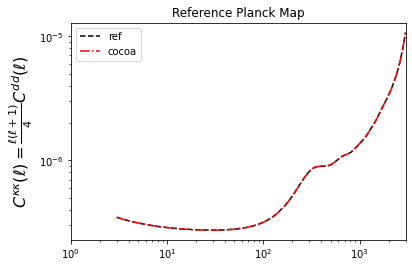

In [16]:
#plt.loglog(nlkk_MV[:,0], nlkk_MV[:,1], ls='--', label='MV')
#plt.loglog(nlkk_PP[:,0], nlkk_PP[:,1], ls='--', label='PP')
#plt.loglog(nlkk_TT[:,0], nlkk_TT[:,1], ls='--', label='TT')
plt.loglog(noise_ref[:,0], noise_ref[:,1], label='ref', color='k', ls='--')
plt.loglog(noise_cocoa[:,0], noise_cocoa[:,1]*noise_cocoa[:,0]*(noise_cocoa[:,0]+1)/(4), 
           label='cocoa', color='r', ls='-.')
plt.legend()
plt.xlim([1,3001])
#plt.ylim([1e-7, 1e-4])
plt.ylabel(r'$C^{\kappa\kappa}(\ell)=\frac{\ell(\ell+1)}{4}C^{dd}(\ell)$', fontsize=16)
plt.title("Reference Planck Map")

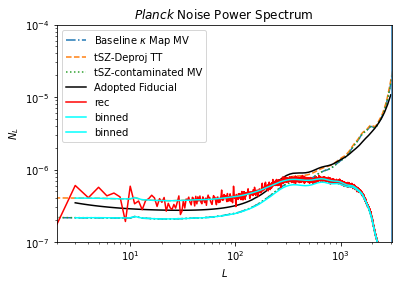

In [40]:
# Reference map
nlkk_SZdeproj = np.genfromtxt(cmb_dir+"/COM_Lensing_Szdeproj_4096_R3.00/TT/nlkk.dat")
nlkk_SZcontm = np.genfromtxt(cmb_dir+"/COM_Lensing_Sz_4096_R3.00/MV/nlkk.dat")
#nlkk_TT = np.genfromtxt(cmb_dir+"/COM_Lensing_4096_R3.00/TT/nlkk.dat")
plt.loglog(nlkk_MV[:,0], nlkk_MV[:,1], ls='-.', label=r'Baseline $\kappa$ Map MV')
plt.loglog(nlkk_SZdeproj[:,0], nlkk_SZdeproj[:,1], ls='--', label='tSZ-Deproj TT')
plt.loglog(nlkk_SZcontm[:,0], nlkk_SZcontm[:,1], ls=':', label='tSZ-contaminated MV')
plt.loglog(noise_ref[:,0], noise_ref[:,1], label='Adopted Fiducial', color='k', ls='-')

plt.loglog(nlkk_MV[:,0], noise_cl_rec, label='rec', color='r')

#plt.loglog(l_cen, nlkk_MV_binned, color='cyan', label='binned')
plt.loglog(l_cen, nlkk_Sz_binned, color='cyan', label='binned')
plt.loglog(l_cen, nlkk_dp_binned, color='cyan', label='binned')

plt.legend(loc='upper left')
plt.xlim([2,3049])
#plt.xlim([2,5096])
plt.ylim([1e-7, 1e-4])
plt.title(r'$Planck$ Noise Power Spectrum')
plt.xlabel(r'$L$')
plt.ylabel(r'$N_L$')
#plt.savefig("figs/CMBNoisePowerSpectrum.png", dpi=300)
plt.axvline(360*60/7)
plt.show()

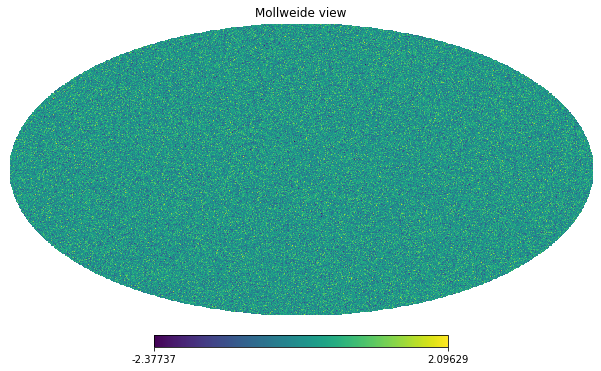

In [15]:
lmax = 4096
Nside=1024
beam_FWHM = 7/60./180.*np.pi
noise_cl = nlkk_SZdeproj[:,1].copy()
#noise_cl[nlkk_MV[:,0]>3071]=0.0
noise_map, noise_alm = hp.sphtfunc.synfast(noise_cl, Nside, lmax=lmax, alm=True, fwhm=beam_FWHM)
noise_cl_rec = hp.sphtfunc.alm2cl(noise_alm, lmax=lmax,)
hp.mollview(noise_map)

In [7]:
def getBinned(Cls, l_min, l_max, Nbins):
    dlogell = np.log10(l_max/l_min)/(Nbins-1)
    l_cen = np.logspace( np.log10(l_min), np.log10(l_max), Nbins )
    l_left = 10**(np.log10(l_cen) - 0.5*dlogell)
    l_right = 10**(np.log10(l_cen) + 0.5*dlogell)

    Cls_binned = np.zeros(Nbins)
    Cls_modect = np.zeros(Nbins)
    
    start = 0
    i = 0
    while i < Cls.shape[0] and start < Nbins:
        ell = Cls[i,0]
        if ell < l_left[start]:
            i += 1
        elif ell >= l_right[start]:
            start += 1
        else:
            
        #if ell >= l_right[start] or ell < l_left[start]:
        #    start += 1
        #    continue
        #if start >= Nbins:
        #    break
            Cls_binned[start] += Cls[i,1]
            Cls_modect[start] += 1
            i += 1
        
    for i in range(Nbins):
        Cls_binned[i] /= Cls_modect[i]
    return Cls_binned, l_cen

In [23]:
def smoothWF(ell, fwhm):
    ell_beam = np.sqrt(16*np.log(2))/fwhm
    return np.exp(-ell*(ell+1)/ell_beam**2)

In [31]:
from scipy.stats import binned_statistic
dlogell = np.log10(3000/3)/(101-1)
l_cen = np.logspace( np.log10(3), np.log10(3000), 101 )
l_edge = 10**(np.log10(l_cen) - 0.5*dlogell)

nlkk_MV_binned = np.interp(l_cen, 
                           nlkk_MV[:,0], 
                           nlkk_MV[:,1]*smoothWF(nlkk_MV[:,0], beam_FWHM)**2 )
nlkk_Sz_binned = np.interp(l_cen, 
                           nlkk_SZcontm[:,0], 
                           nlkk_SZcontm[:,1]*smoothWF(nlkk_SZcontm[:,0], beam_FWHM)**2 )
nlkk_dp_binned = np.interp(l_cen, 
                           nlkk_SZdeproj[:,0], 
                           nlkk_SZdeproj[:,1]*smoothWF(nlkk_SZdeproj[:,0], beam_FWHM)**2 )

In [41]:
np.savetxt("../cmblensrec/plancksmica/cmb_ref_smoothed_7arcmin.txt", 
           np.c_[l_cen, nlkk_MV_binned], fmt='%.15e %.15e')
np.savetxt("../cmblensrec/plancksmica/cmb_tSZ_contaminated_smoothed_7arcmin.txt", 
           np.c_[l_cen, nlkk_Sz_binned], fmt='%.15e %.15e')
np.savetxt("../cmblensrec/plancksmica/cmb_tSZ_deprojected_smoothed_7arcmin.txt", 
           np.c_[l_cen, nlkk_dp_binned], fmt='%.15e %.15e')